In [1]:
REP_DIR = '/home/graffc/extra/fire_prediction/'
SRC_DIR = REP_DIR + 'src/'
DATA_DIR = REP_DIR + 'data/'

# Load system-wide packages
import os
import functools
from matplotlib import pyplot as plt
import numpy as np
from scipy.stats import cumfreq
from scipy.stats.stats import pearsonr
import datetime as dt
import pytz
import seaborn as sb
from collections import Counter, defaultdict
from tabulate import tabulate
from matplotlib import gridspec
from IPython.core.display import Image, display
import pandas as pd
%matplotlib inline

# Load project packages
os.chdir(SRC_DIR)
import helper.loaders as load
from features.loaders import load_modis_df, load_gfs_weather
from helper import date_util as du
from visualization.mapping import make_map
from helper.geometry import get_default_bounding_box
import visualization.mapping as vmap
from helper.geometry import LatLonBoundingBox
import evaluation.evaluate_model as evm
import evaluation.setup_data_structs as setup_ds

import evaluation.metrics as metrics
import evaluation.setup_data_structs as setup_ds
import evaluation.evaluate_model as evm
import evaluation.model_configs as model

In [2]:
# Days to predict
T_K_MAX = 5
T_K_ARR = np.arange(1,T_K_MAX+1)

# Years to use
YEAR_START, YEAR_END = 2007, 2016
YEARS_ARR = np.arange(YEAR_START, YEAR_END+1)

# === DATA FILES ===
land_cover_src = os.path.join(DATA_DIR, 'interim/land_cover/land_cover_alaska.pkl')
weather_proc_region_src = os.path.join(DATA_DIR, 'interim/gfs/weather_proc/4/weather_proc_gfs_4_alaska_2007-2016.pkl')
ignition_cube_src = os.path.join(DATA_DIR, 'interim/modis/fire_cube/fire_ignition_cube_modis_alaska_2007-2016.pkl')
detection_cube_src = os.path.join(DATA_DIR, 'interim/modis/fire_cube/fire_detection_cube_modis_alaska_2007-2016.pkl')

integrated_cluster_df_fmt = 'interim/integrated/fire_weather/fire_weather_integrated_gfs_4_modis_5km_10days_forwards_day_cents_1400_%dk_alaska_2007-2016.pkl'
integrated_cluster_df_src_list = map(lambda k: (k, os.path.join(DATA_DIR, integrated_cluster_df_fmt % k)), T_K_ARR)

In [3]:
# === DATA LOADING ===
modis_df = pd.read_pickle(os.path.join(DATA_DIR, 'interim/modis/fire/fire_modis_alaska_2007-2016.pkl'))
cluster_id_5km_10day_df = pd.read_pickle(os.path.join(DATA_DIR, 'interim/modis/fire_cluster/old/fire_cluster_ids_5km_10days_modis_alaska_2007-2016.pkl'))
land_cover = load.load_pickle(land_cover_src)
weather_proc_region = load.load_pickle(weather_proc_region_src)
gfs = load_gfs_weather(os.path.join(DATA_DIR, 'interim/gfs/weather_proc/4/weather_proc_gfs_4_alaska_2007-2016.pkl'))
X_ignition_c, Y_detection_c = evm.setup_ignition_data(ignition_cube_src, detection_cube_src)


X_active_df = evm.setup_multiple_active_fire_data(integrated_cluster_df_src_list)

In [4]:
# Add local_time column to modis_df
modis_df = modis_df.assign(datetime_local=map(lambda x: du.utc_to_local_time(x[0], x[1], du.round_to_nearest_quarter_hour), zip(modis_df.datetime_utc, modis_df.lon)))

# Add year column to cluste_ids
cluster_id_5km_10day_df['year'] = cluster_id_5km_10day_df.datetime_utc.dt.year

### Temporal distribution of detections (spearated by satellite)

In [5]:
# Helper functions MODIS
def dt_to_hours_frac(dt):
    return dt.hour + (dt.minute / 60.)

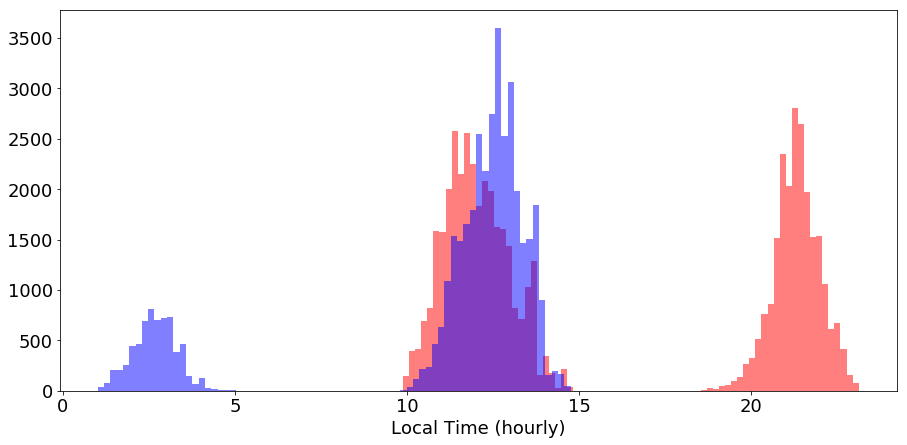

In [52]:
plt.rcParams['figure.figsize'] = [15,7]

font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 18}

plt.rc('font', **font)

# Plot a histogram of the times of measurements across all of Alaska (Aqua vs Terra)
times_terra = map(dt_to_hours_frac, modis_df[modis_df.sat=='T'].datetime_local)
times_aqua = map(dt_to_hours_frac, modis_df[modis_df.sat=='A'].datetime_local)

_ = plt.hist(times_terra, 75, facecolor='red', alpha=.5)
_ = plt.hist(times_aqua, 75, facecolor='blue', alpha=.5)
#_ = plt.title('Time distribution of fire detections')
_ = plt.xlabel('Local Time (hourly)')

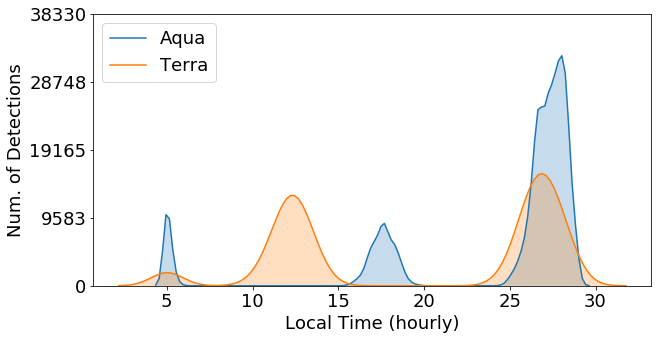

In [50]:
plt.rcParams['figure.figsize'] = [10,5]

font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 18}

plt.rc('font', **font)


times_terra = map(dt_to_hours_frac, modis_df[modis_df.sat=='T'].datetime_local)
times_aqua = map(dt_to_hours_frac, modis_df[modis_df.sat=='A'].datetime_local)

# Plot a KDE of the times of measurements across all of Alaska (Aqua vs Terra)
fig = sb.kdeplot(times_aqua, shade=True, label='Aqua')
sb.kdeplot(times_terra, shade=True, label='Terra')

plt.yticks(fig.get_yticks(), np.round(fig.get_yticks() * len(modis_df)).astype(np.int32))

#_ = plt.title('Time distribution of fire detections')
_ = plt.xlabel('Local Time (hourly)')
_ = plt.ylabel('Num. of Detections')

### Spatial detections plot

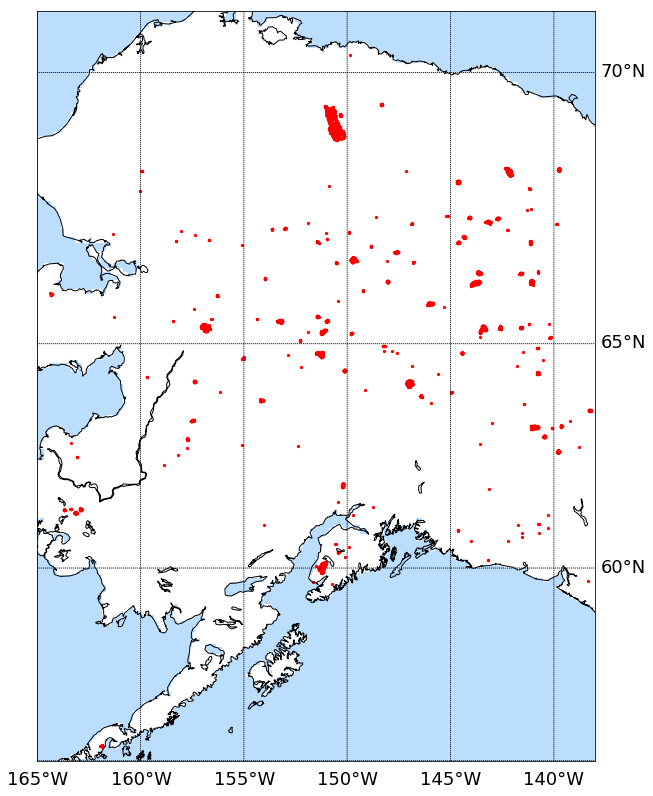

In [401]:
plt.rcParams['figure.figsize'] = [10,15]

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}

plt.rc('font', **font)

ALASKA_BB = get_default_bounding_box()
YEAR_SEL = 2007

mp = vmap.make_map(ALASKA_BB, (5,0,5,0))
mp.drawlsmask(land_color='w', ocean_color=(30./256,144./256,255./256,.3))

b = np.array(map(lambda x: x.year, np.array(modis_df.datetime_local)))==YEAR_SEL
#c = np.array(map(lambda x: x.dayofyear, np.array(modis_df.datetime_local)))==241
#d = np.array(map(lambda x: x.dayofyear, np.array(modis_df.datetime_local)))<241
#b = b & c

sel_df = modis_df[b]
_ = mp.scatter(list(sel_df.lon), list(sel_df.lat), 5, latlon=True, marker='o', color='r')
#_ = plt.title('Detections for %d' % YEAR_SEL)

### Individual cluster plot (with coloring for day of year)

2007-05-01 12:34:00-09:45 2007-09-13 10:46:00-10:00


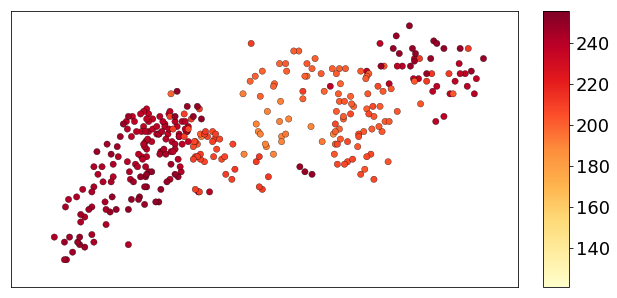

In [428]:
plt.rcParams['figure.figsize'] = [10,15]

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}

plt.rc('font', **font)

# Plot an indvidual cluster
start = modis_df[b].datetime_local.iloc[0]
end = modis_df[b].datetime_local.iloc[4600]

sel_BB = LatLonBoundingBox(66.15,66.26,-144.05,-143.55)

mp = vmap.make_map(sel_BB, (0,0,0,0))

print start,end
sel_df1 = modis_df[b & (modis_df.datetime_local>=start) & (modis_df.datetime_local<=end)]
dayofyear = sel_df1.datetime_utc.dt.dayofyear
cs = mp.scatter(list(sel_df1.lon), list(sel_df1.lat), 40, latlon=True, edgecolor='black', linewidth='.3', c=dayofyear, cmap='YlOrRd')
cbar = mp.colorbar(cs,location='right',pad="5%")
#_ = plt.title('Detections)

### Unconditional, ignition, and active cell dist.

0.0468084147258
11.1058558559
0.00731729630501


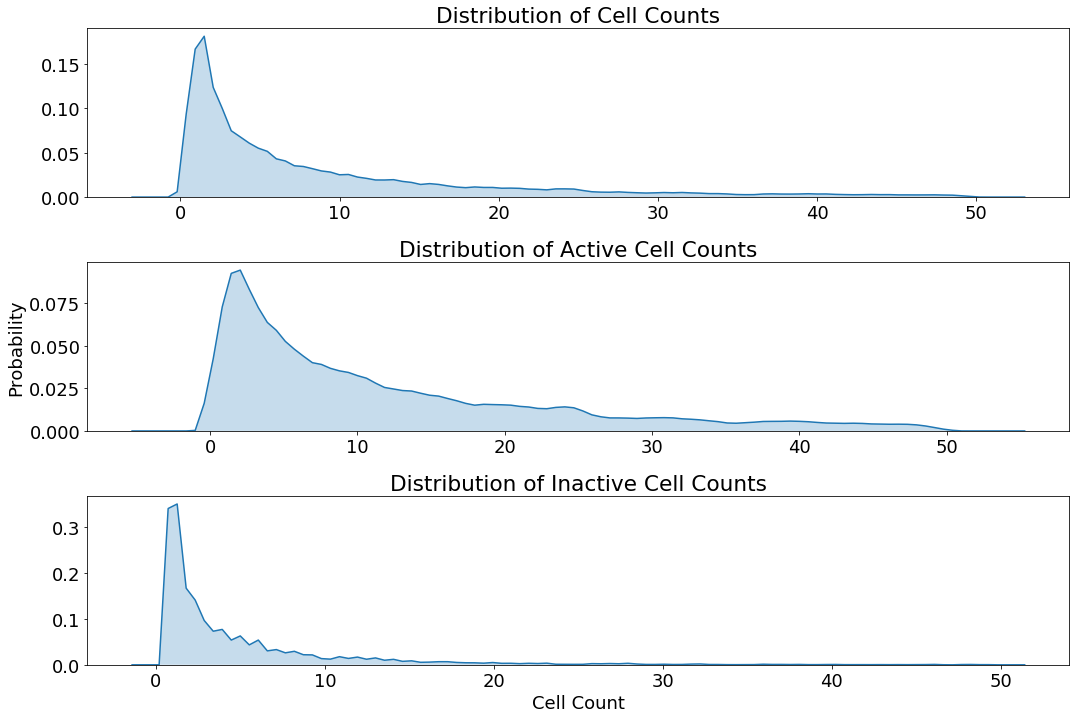

In [435]:
plt.rcParams['figure.figsize'] = [15,10]

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}

plt.rc('font', **font)

fig = plt.figure()

KERNEL = 'biw'

values = Y_detection_c.values
values_flat = values.flatten()

# Plot a KDE of the unconditional cell counts
ax = fig.add_subplot(311)
ax.set_title("Distribution of Cell Counts")
sb.kdeplot(values_flat, clip=(0,np.max(50)), shade=True, kernel=KERNEL)

#_ = plt.xlabel('Cell Count')
#_ = plt.ylabel('Probability')

# Plot a KDE of the active cell counts
ax = fig.add_subplot(312)
ax.set_title("Distribution of Active Cell Counts")

values_shift = np.concatenate([np.zeros(values.shape[:-1]+(1,)), values[:,:,:-1]], axis=2)
values_active = values[values_shift!=0]

values_active_flat = values_active.flatten()

sb.kdeplot(values_active_flat, clip=(0,np.max(50)), shade=True, kernel=KERNEL)

#_ = plt.xlabel('Cell Count')
_ = plt.ylabel('Probability')


# Plot a KDE of the active cell counts
ax = fig.add_subplot(313)
ax.set_title("Distribution of Inactive Cell Counts")

values_inactive = values[values_shift==0]
values_inactive_flat = values_inactive.flatten()

sb.kdeplot(values_inactive_flat, clip=(0,np.max(50)), shade=True, kernel=KERNEL)

_ = plt.xlabel('Cell Count')
#_ = plt.ylabel('Probability')

plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)


print np.mean(values)
print np.mean(values_active)
print np.mean(values_inactive)

0.046808414725770096
11.105855855855856
0.007317296305009159


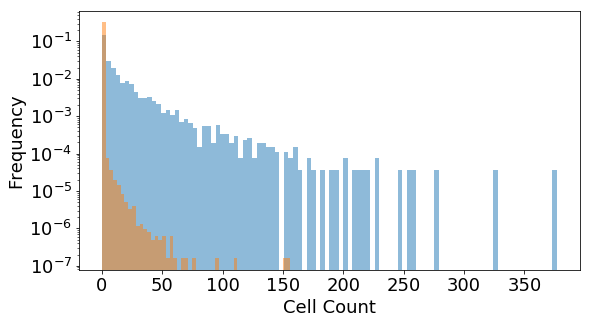

In [39]:
plt.rcParams['figure.figsize'] = [8,4.5]

font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 18}

plt.rc('font', **font)

BINS = 100

fig = plt.figure()

values = Y_detection_c.values
values_flat = values.flatten()

# Plot a KDE of the unconditional cell counts
#ax = fig.add_subplot(311)
#ax.set_title("Distribution of Cell Counts")
#sb.distplot(values_flat, kde=False, bins=BINS)


#_ = plt.xlabel('Cell Count')
#_ = plt.ylabel('Probability')

# Plot a KDE of the active cell counts
#ax = fig.add_subplot(211)
#ax.set_title("Distribution of Active Cell Counts")

values_shift = np.concatenate([np.zeros(values.shape[:-1]+(1,)), values[:,:,:-1]], axis=2)
values_active = values[values_shift!=0]

values_active_flat = values_active.flatten()

plt.hist(values_active_flat, alpha=.5, bins=BINS, normed=True, label='Active')

#_ = plt.xlabel('Cell Count')
#_ = plt.ylabel('Probability')


# Plot a KDE of the active cell counts
#ax = fig.add_subplot(212)
#ax.set_title("Distribution of Inactive Cell Counts")

values_inactive = values[values_shift==0]
values_inactive_flat = values_inactive.flatten()

plt.hist(values_inactive_flat, alpha=.5, bins=BINS/2, normed=True, label='Ignition')

_ = plt.xlabel('Cell Count')
_ = plt.ylabel('Frequency')

plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

map(lambda x: x.set_yscale('log'), fig.get_axes())

print np.mean(values)
print np.mean(values_active)
print np.mean(values_inactive)

https://stats.stackexchange.com/questions/65866/good-methods-for-density-plots-of-non-negative-variables-in-r

#### Truncate negative values and reweight
#### Estimating density using splines (Kooperberg)

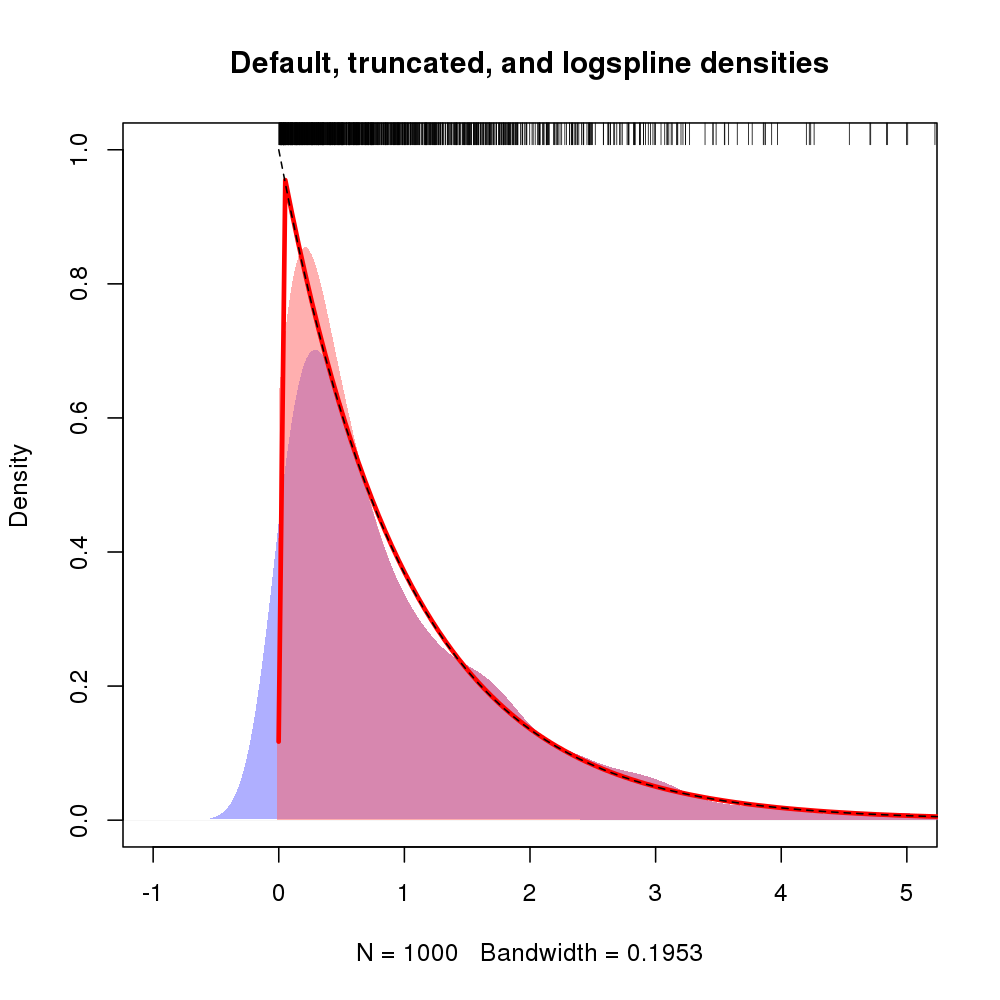

In [441]:
display(Image('https://i.stack.imgur.com/633iI.png', width=500, unconfined=True))

0.0468084147258
11.1058558559
0.00731729630501


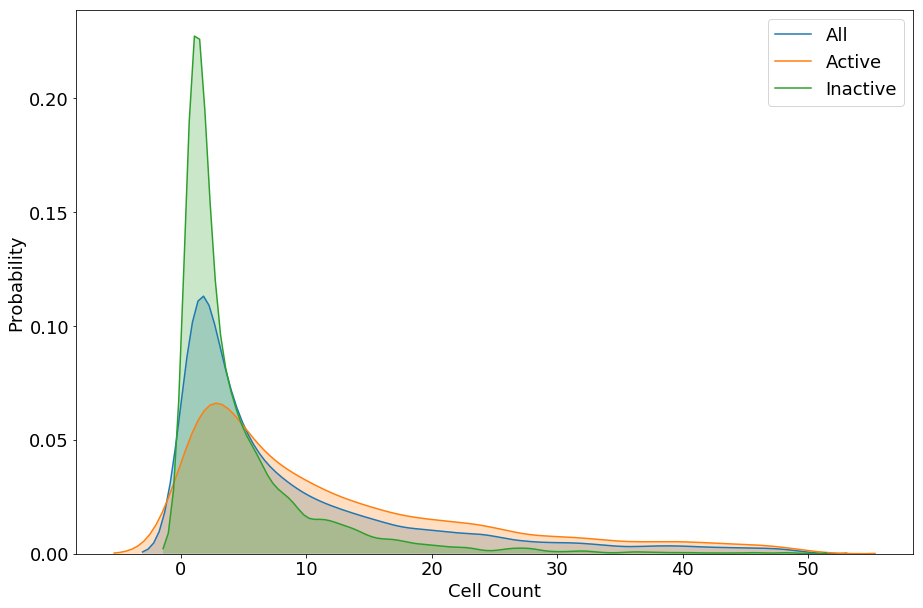

In [443]:
plt.rcParams['figure.figsize'] = [15,10]

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}

plt.rc('font', **font)

values = Y_detection_c.values
values_flat = values.flatten()

# Plot a KDE of the unconditional cell counts
sb.kdeplot(values_flat, clip=(0,np.max(50)), shade=True, label='All')
_ = plt.xlabel('Cell Count')
_ = plt.ylabel('Probability')
#_ = plt.title('Distribution of Cell Counts')

# Plot a KDE of the active cell counts

values_shift = np.concatenate([np.zeros(values.shape[:-1]+(1,)), values[:,:,:-1]], axis=2)
values_active = values[values_shift!=0]

values_active_flat = values_active.flatten()

sb.kdeplot(values_active_flat, clip=(0,np.max(50)), shade=True, label='Active')

# Plot a KDE of the inactive cell counts
values_inactive = values[values_shift==0]
values_inactive_flat = values_inactive.flatten()

sb.kdeplot(values_inactive_flat, clip=(0,np.max(50)), shade=True, label='Inactive')

print np.mean(values)
print np.mean(values_active)
print np.mean(values_inactive)

### Cluster Size Dist.

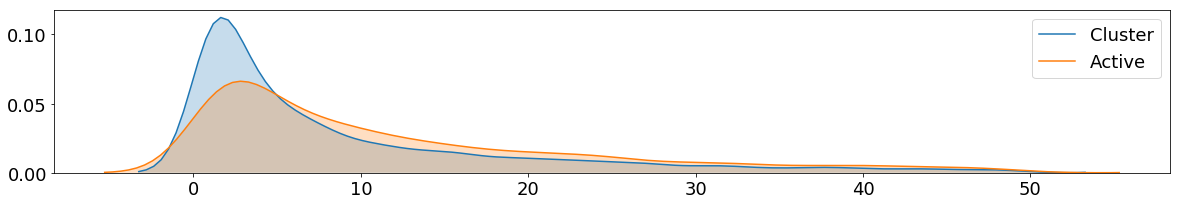

In [296]:
plt.rcParams['figure.figsize'] = [20,3]

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}

plt.rc('font', **font)

ax.set_title("Distribution of Cluster Counts")
_ = sb.kdeplot(X_active_df[1].num_det, clip=(0,np.max(50)), shade=True, label='Cluster')
sb.kdeplot(values_active_flat, clip=(0,np.max(50)), shade=True, label='Active')

### Cluster lifetimes vs. covariates (blanket plot)

### Summary Statistics

In [25]:
num_det = Counter(modis_df.datetime_utc.dt.year)
keys = num_det.keys()
keys.sort()


num_det = [num_det[k] for k in keys]
num_clust = list(cluster_id_5km_10day_df.groupby('year').cluster_id.nunique())

# Add climate
years = np.array(map(lambda x: x.year, gfs.dates))
temp = []
humid = []
for year in range(2007, 2016+1):
    vals = gfs['temperature'].filter_dates(dt.datetime(year, 5,14, 0, 0, 0, tzinfo=pytz.UTC), dt.datetime(year, 8,31, 11, 59, 59, tzinfo=pytz.UTC)).values
    temp.append(np.nanmean(vals[15:20,25:35,:]))
    
    vals = gfs['humidity'].filter_dates(dt.datetime(year, 5,14, 0, 0, 0, tzinfo=pytz.UTC), dt.datetime(year, 8,31, 11, 59, 59, tzinfo=pytz.UTC)).values
    humid.append(np.nanmean(vals[15:20,25:35,:]))
    
temp_a = list(temp - np.mean(temp))
humid_a = list(humid - np.mean(humid))

# Add means and std dev
num_det += [np.mean(num_det), np.std(num_det)]
num_clust += [np.mean(num_clust), np.std(num_clust)]
#temp += [np.mean(temp), np.std(temp)]
#humid += [np.mean(humid), np.std(humid)]
temp_a += [np.mean(temp), np.std(temp)]
humid_a += [np.mean(humid), np.std(humid)]

# Round values
num_det = map(lambda x: round(x), num_det)
num_clust = map(lambda x: round(x), num_clust)
#temp = map(lambda x: round(x, 1), temp)
#humid = map(lambda x: round(x, 1), humid)
temp_a = map(lambda x: round(x, 1), temp_a)
humid_a = map(lambda x: round(x, 1), humid_a)

# Add row names
num_det = ['Num. of Detections'] + num_det
num_clust = ['Num. of Clusters'] + num_clust
#temp = ['Mean Temp.'] + temp
#humid = ['Mean Humid.'] + humid
temp_a = ['Temp. Anomaly'] + temp_a
humid_a = ['Humid. Anomaly'] + humid_a

headers = keys + ['Mean', 'Std.']
rows = [num_det, num_clust, temp_a, humid_a]

print tabulate(rows, headers=headers, tablefmt='latex')

\begin{tabular}{lrrrrrrrrrrrr}
\hline
                    &   2007 &   2008 &    2009 &   2010 &   2011 &   2012 &   2013 &   2014 &    2015 &   2016 &   Mean &    Std. \\
\hline
 Num. of Detections & 5109   & 1077   & 29423   & 7997   & 1658   & 1381   & 9323   & 1273   & 34808   & 3777   & 9583   & 11652   \\
 Num. of Clusters   &  170   &   49   &   168   &  191   &   90   &   74   &  220   &   47   &   401   &  126   &  154   &   100   \\
 Temp. Anomaly      &   -0.1 &   -2.1 &     0.5 &   -0.4 &   -0.7 &   -0.7 &    1.1 &   -0   &     1.3 &    1.1 &  281.9 &     1   \\
 Humid. Anomaly     &    0.5 &    4   &    -4.3 &    2.7 &    1.9 &    2.3 &   -2.5 &   -1.4 &    -4.7 &    1.5 &   75.8 &     2.9 \\
\hline
\end{tabular}


### Topography, land cover, and temp. maps

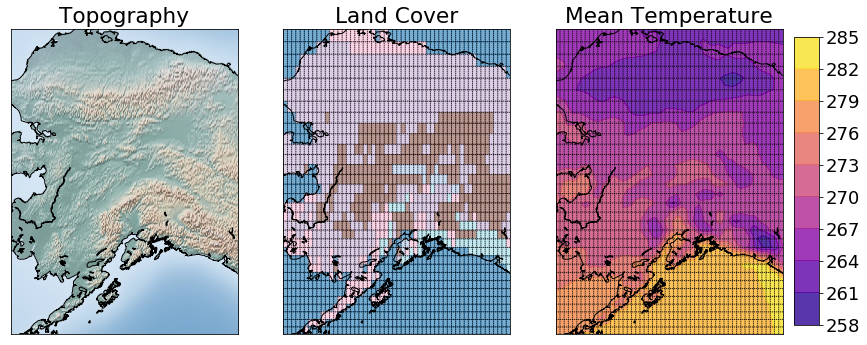

In [478]:
plt.rcParams['figure.figsize'] = [15,25]

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}

plt.rc('font', **font)

# Plot 1x3 of topography, land cover and temp
BOUNDING_BOX = weather_proc_region.bounding_box 
fig = plt.figure()

# Plot topography
ax = fig.add_subplot(131)
ax.set_title("Topography")
mp = make_map(BOUNDING_BOX, (0,0,0,0))
mp.shadedrelief()

# Plot land cover
ax = fig.add_subplot(132)
ax.set_title("Land Cover")

mp = make_map(BOUNDING_BOX, (0, .5, 0, .5))
#mp.shadedrelief()

values = np.argmax(land_cover, axis=2)
lats, lons = BOUNDING_BOX.make_grid()

cs = mp.pcolormesh(lons, lats , values, latlon=True, alpha=.6, cmap='tab20')
#cbar = mp.colorbar(cs,location='bottom',pad="5%")

# Plot temperature
ax = fig.add_subplot(133)
ax.set_title("Mean Temperature")

DATA_TYPE = 'temperature'   

mp = make_map(gfs[DATA_TYPE].bounding_box,  (0, .5, 0, .5))
#mp.shadedrelief()

values = np.nanmean(gfs['temperature'].values, axis=2)
lats, lons = gfs[DATA_TYPE].bounding_box.make_grid()

cs = mp.contourf(lons, lats , values, latlon=True, alpha=.8, cmap='plasma')
#cbar = mp.colorbar(cs,location='right',pad="5%")

fig.subplots_adjust(right=0.84)
cbar_ax = fig.add_axes([0.85, .423, 0.023, 0.16])
_ = fig.colorbar(cs, cax=cbar_ax)

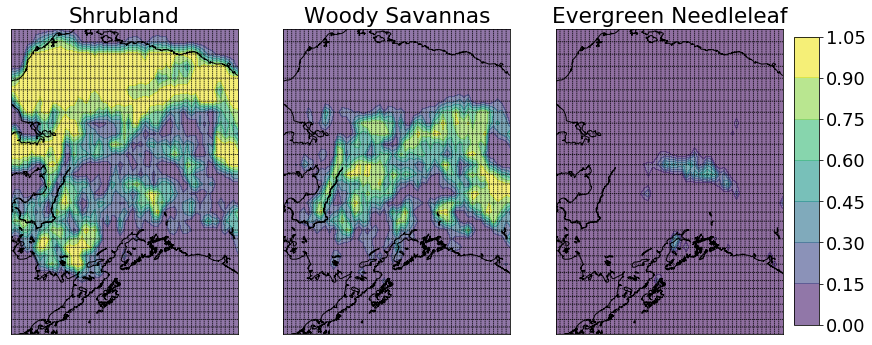

In [35]:
plt.rcParams['figure.figsize'] = [15,25]

font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 18}

plt.rc('font', **font)

fig = plt.figure()

ax = fig.add_subplot(131)
ax.set_title("Shrubland")

mp = make_map(BOUNDING_BOX, (0, .5, 0, .5))
#mp.shadedrelief()

values = land_cover[:,:,7]/100
lats, lons = BOUNDING_BOX.make_grid()

cs0 = mp.contourf(lons, lats , values, latlon=True, alpha=.6, vmin=0, vmax=1)

ax = fig.add_subplot(132)
ax.set_title("Woody Savannas")
mp = make_map(BOUNDING_BOX, (0, .5, 0, .5))
values = land_cover[:,:,8]/100

cs1 = mp.contourf(lons, lats , values, latlon=True, alpha=.6, vmin=0, vmax=1)

ax = fig.add_subplot(133)
ax.set_title("Evergreen Needleleaf")
mp = make_map(BOUNDING_BOX, (0, .5, 0, .5))
values = land_cover[:,:,1]/100

cs2 = mp.contourf(lons, lats , values, latlon=True, alpha=.6, vmin=0, vmax=1)

fig.subplots_adjust(right=0.84)
cbar_ax = fig.add_axes([0.85, .423, 0.023, 0.16])
cb = fig.colorbar(cs0, cax=cbar_ax)

### Clustered detections vs. fire boundaries

In [484]:
np.sum(land_cover.reshape(33*55, 17), axis=0)/100

array([  6.66520000e+02,   1.80500000e+01,   0.00000000e+00,
         1.00000000e-02,   1.90000000e-01,   1.22500000e+01,
         0.00000000e+00,   5.87860000e+02,   3.03840000e+02,
         1.97000000e+00,   1.63630000e+02,   8.80000000e-01,
         1.00000000e-02,   6.00000000e-02,   4.40000000e-01,
         5.61800000e+01,   3.11000000e+00])

## === Results & Error Analysis ===

In [7]:
YEARS_TRAIN = [2007,2008,2009,2010, 2011, 2012, 2013, 2014, 2015, 2016]
YEARS_TEST = [2007,2008,2009,2010, 2011, 2012, 2013, 2014, 2015, 2016]
T_K_ARR = np.arange(1,T_K_MAX+1)

y_grid_dict = setup_ds.build_y(Y_detection_c, T_K_ARR, YEARS_TRAIN)
X_active_dict = setup_ds.build_x_active(X_active_df, T_K_ARR, YEARS_TRAIN)
X_grid_dict = setup_ds.build_x_grid(weather_proc_region, Y_detection_c, land_cover, T_K_ARR, 15, 15, [2,5,10], [.25, .5, .75], [5,10,15], YEARS_TRAIN)

T_k=1 T_k=2 T_k=3 T_k=4 T_k=5


In [497]:
# Get results of persistence model
results_auto_grid, models_auto_grid = evm.evaluate_model_params(model.auto_grid_model, {'None': []}, X_grid_dict, y_grid_dict, YEARS_TEST, T_K_ARR)

# Get results of poisson w/ climate
results_active_only_grid, models_active_only_grid = evm.evaluate_model_params(model.active_only_grid_model_poisson, {'All': ['temperature','humidity','wind','rain']}, X_grid_dict, y_grid_dict, None, T_K_ARR)

# Get results of poisson w/ memory (no climate)
results_active_only_grid_mem, models_active_only_grid_mem = evm.evaluate_model_params(model.active_only_grid_model_poisson, {'Memory' : ['num_det_' + str(i) for i in range(1,10)]}, X_grid_dict, y_grid_dict, None, T_K_ARR)

# Get results of zip w/ memory (no climate)
results_active_grid_all_zip, models_active_grid_all_zip = evm.evaluate_model_params(model.active_only_grid_model_zip, {'Memory' : ['num_det_' + str(i) for i in range(1,10)]}, X_grid_dict, y_grid_dict, None, T_K_ARR)


ImportError: cannot import name GeneralizedPoisson

[1, 2, 3, 4, 5]

### Comparison of models using fixed covariates (table w/ skill score)

### Comparison of Poisson and linear regr. (table w/ skill score)

### Comparison of Covariates for best model (table w/ skill score)

### Model coeff. (normalized and unnormalized)

### Simulation of learned coeff.

### Spatial errors

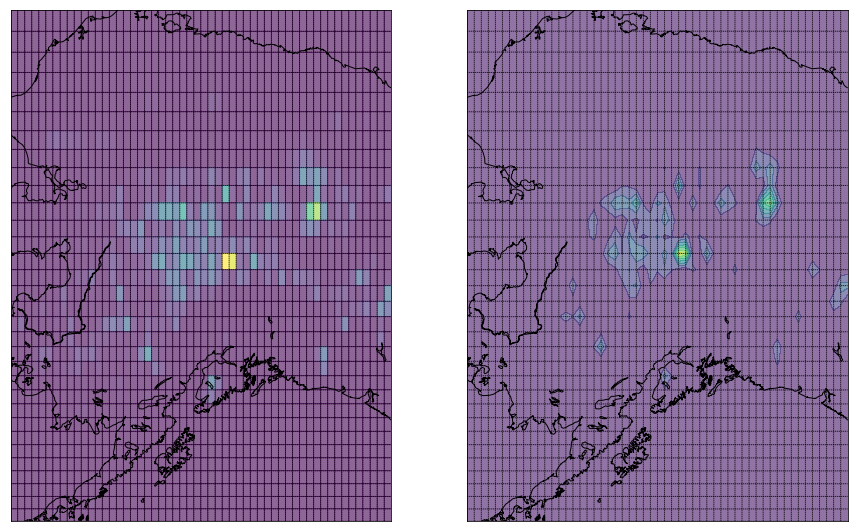

In [57]:
plt.rcParams['figure.figsize'] = [15,10]

ALASKA_BB = get_default_bounding_box()

fig = plt.figure()

ax = fig.add_subplot(121)

mp = make_map(ALASKA_BB,  (0, .5, 0, .5))

values = np.mean(Y_detection_c.values, axis=2)
lats, lons = ALASKA_BB.make_grid()

cs = mp.pcolormesh(lons, lats , values, latlon=True, alpha=.6)

ax = fig.add_subplot(122)
mp = make_map(ALASKA_BB,  (0, .5, 0, .5))
cs = mp.contourf(lons, lats , values, latlon=True, alpha=.6)

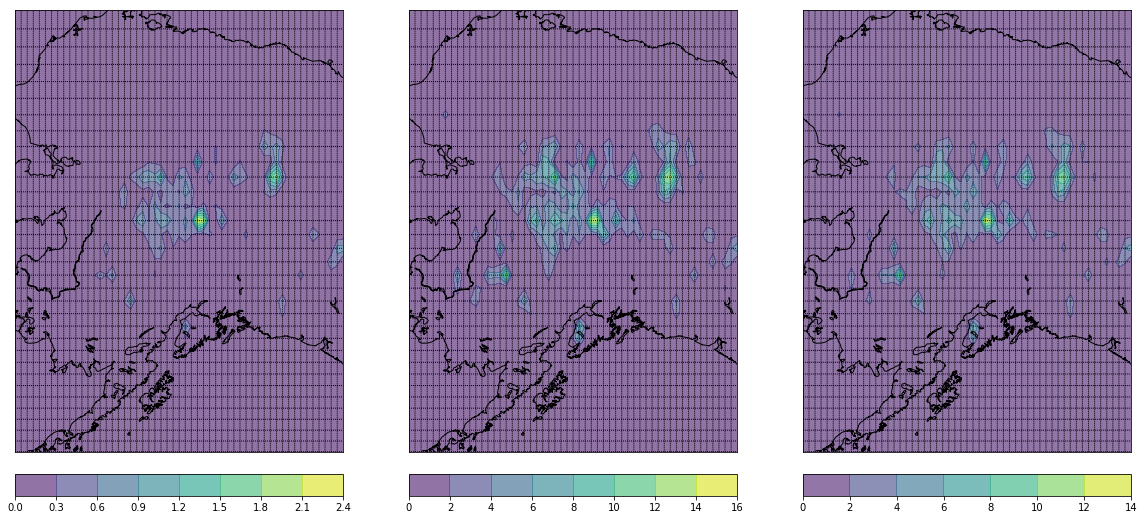

In [58]:
plt.rcParams['figure.figsize'] = [20,10]

ALASKA_BB = get_default_bounding_box()

fig = plt.figure()

# Plot mean counts
ax = fig.add_subplot(131)

values = np.mean(Y_detection_c.values, axis=2)

mp = make_map(ALASKA_BB,  (0, .5, 0, .5))
lats, lons = ALASKA_BB.make_grid()
cs = mp.contourf(lons, lats , values, latlon=True, alpha=.6)
cbar = mp.colorbar(cs,location='bottom',pad="5%")

# Plot RMSE of persistence
ax = fig.add_subplot(132)

metric = metrics.root_mean_squared_error
values = metric(results_auto_grid[1]['None'][0][0], results_auto_grid[1]['None'][0][1], axis=2)

mp = make_map(ALASKA_BB,  (0, .5, 0, .5))
cs = mp.contourf(lons, lats , values, latlon=True, alpha=.6)
cbar = mp.colorbar(cs,location='bottom',pad="5%")

# Plot RMSE of poisson w/ climate
ax = fig.add_subplot(133)

metric = metrics.root_mean_squared_error
values = metric(results_active_only_grid[1]['All'][0][0], results_active_only_grid[1]['All'][0][1], axis=2)

mp = make_map(ALASKA_BB,  (0, .5, 0, .5))
cs = mp.contourf(lons, lats , values, latlon=True, alpha=.6)
cbar = mp.colorbar(cs,location='bottom',pad="5%")

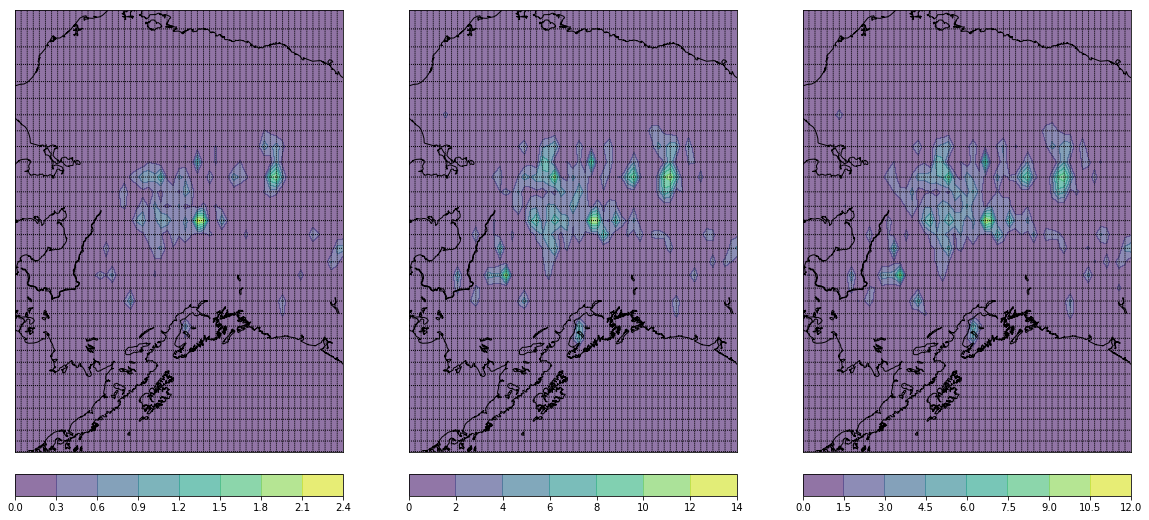

In [59]:
plt.rcParams['figure.figsize'] = [20,10]

ALASKA_BB = get_default_bounding_box()

fig = plt.figure()

# Plot mean counts
ax = fig.add_subplot(131)

values = np.mean(Y_detection_c.values, axis=2)

mp = make_map(ALASKA_BB,  (0, .5, 0, .5))
lats, lons = ALASKA_BB.make_grid()
cs = mp.contourf(lons, lats , values, latlon=True, alpha=.6)
cbar = mp.colorbar(cs,location='bottom',pad="5%")

# Plot RMSE of persistence
ax = fig.add_subplot(132)

metric = metrics.root_mean_squared_error
values = metric(results_auto_grid[1]['None'][0][0], results_auto_grid[1]['None'][0][1], axis=2)
values = values - np.mean(Y_detection_c.values, axis=2)

mp = make_map(ALASKA_BB,  (0, .5, 0, .5))
cs = mp.contourf(lons, lats , values, latlon=True, alpha=.6)
cbar = mp.colorbar(cs,location='bottom',pad="5%")

# Plot RMSE of poisson w/ climate
ax = fig.add_subplot(133)

metric = metrics.root_mean_squared_error
values = metric(results_active_only_grid[1]['All'][0][0], results_active_only_grid[1]['All'][0][1], axis=2)
values = values - np.mean(Y_detection_c.values, axis=2)

mp = make_map(ALASKA_BB,  (0, .5, 0, .5))
cs = mp.contourf(lons, lats , values, latlon=True, alpha=.6)
cbar = mp.colorbar(cs,location='bottom',pad="5%")

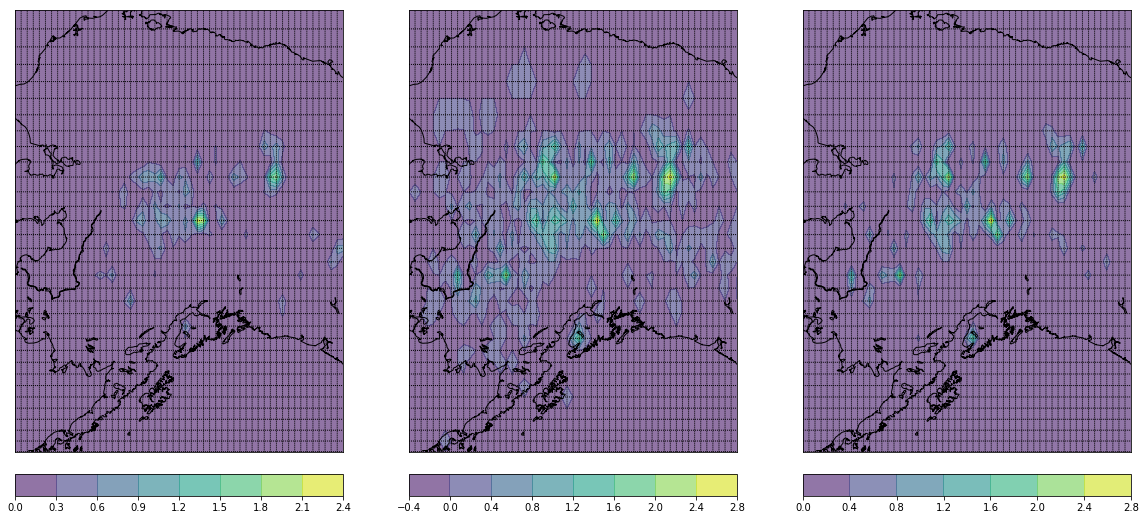

In [60]:
plt.rcParams['figure.figsize'] = [20,10]

ALASKA_BB = get_default_bounding_box()

fig = plt.figure()

# Plot mean counts
ax = fig.add_subplot(131)

values = np.mean(Y_detection_c.values, axis=2)

mp = make_map(ALASKA_BB,  (0, .5, 0, .5))
lats, lons = ALASKA_BB.make_grid()
cs = mp.contourf(lons, lats , values, latlon=True, alpha=.6)
cbar = mp.colorbar(cs,location='bottom',pad="5%")

# Plot RMSE
ax = fig.add_subplot(132)

metric = metrics.root_mean_squared_error
error1 = metric(results_active_only_grid[1]['All'][0][0], results_active_only_grid[1]['All'][0][1], axis=2)
error2 = metric(results_auto_grid[1]['None'][0][0], results_auto_grid[1]['None'][0][1], axis=2)

values = error2 - error1

mp = make_map(ALASKA_BB,  (0, .5, 0, .5))
cs = mp.contourf(lons, lats , values, latlon=True, alpha=.6)
cbar = mp.colorbar(cs,location='bottom',pad="5%")

# Plot RMSE
ax = fig.add_subplot(133)

values = np.abs(error2 - error1)

mp = make_map(ALASKA_BB,  (0, .5, 0, .5))
cs = mp.contourf(lons, lats , values, latlon=True, alpha=.6)
cbar = mp.colorbar(cs,location='bottom',pad="5%")

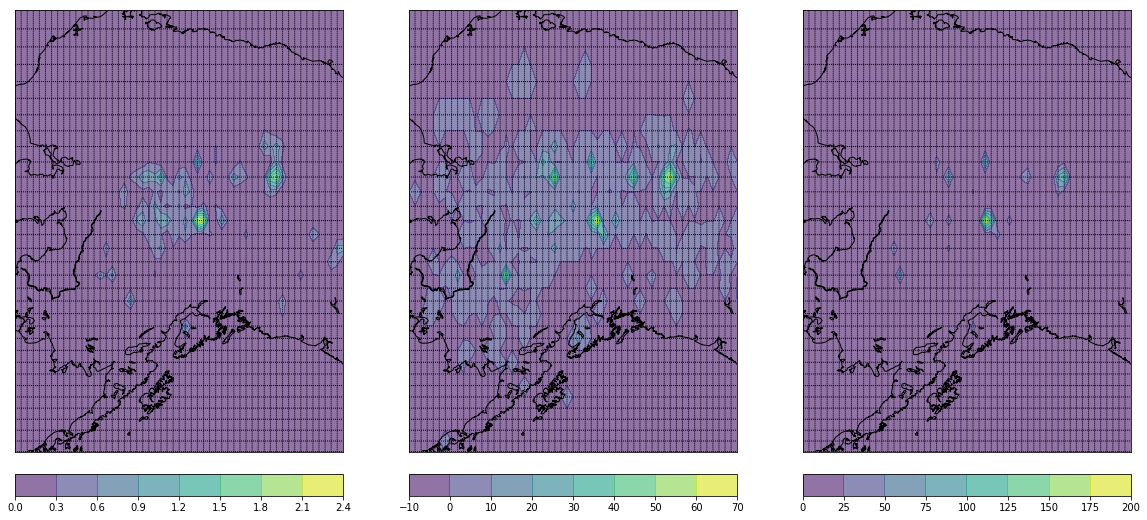

In [63]:
plt.rcParams['figure.figsize'] = [20,10]

ALASKA_BB = get_default_bounding_box()

fig = plt.figure()

# Plot mean counts
ax = fig.add_subplot(131)

values = np.mean(Y_detection_c.values, axis=2)

mp = make_map(ALASKA_BB,  (0, .5, 0, .5))
lats, lons = ALASKA_BB.make_grid()
cs = mp.contourf(lons, lats , values, latlon=True, alpha=.6)
cbar = mp.colorbar(cs,location='bottom',pad="5%")

# Plot RMSE
ax = fig.add_subplot(132)


error1 = np.square(results_active_only_grid[1]['All'][0][1] - results_active_only_grid[1]['All'][0][0])
error2 = np.square(results_auto_grid[1]['None'][0][1] - results_auto_grid[1]['None'][0][0])

values = np.mean(error2 - error1, axis=2)

mp = make_map(ALASKA_BB,  (0, .5, 0, .5))
cs = mp.contourf(lons, lats , values, latlon=True, alpha=.6)
cbar = mp.colorbar(cs,location='bottom',pad="5%")

# Plot RMSE
ax = fig.add_subplot(133)

values = np.mean(np.abs(error2 - error1), axis=2)

mp = make_map(ALASKA_BB,  (0, .5, 0, .5))
cs = mp.contourf(lons, lats , values, latlon=True, alpha=.6)
cbar = mp.colorbar(cs,location='bottom',pad="5%")

### Temporal errors

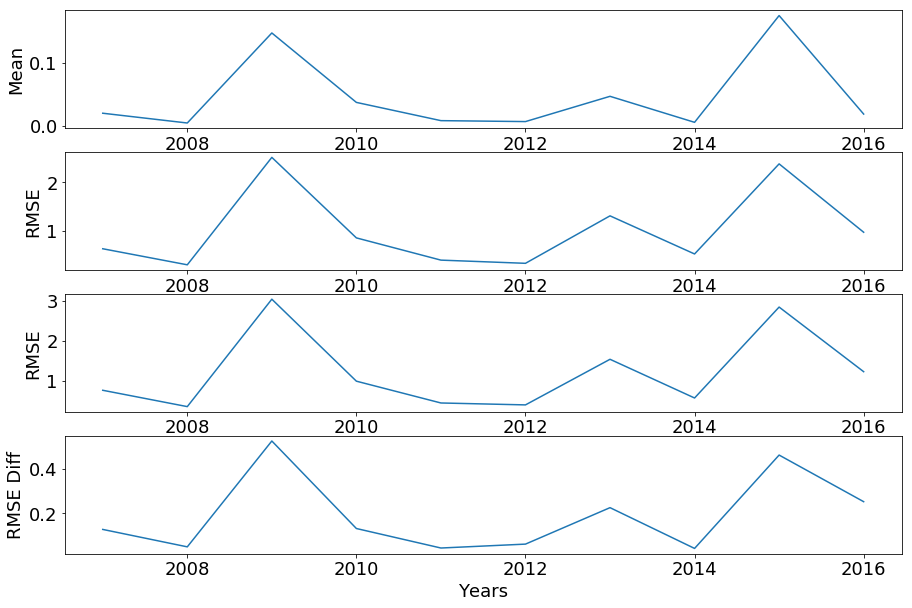

In [108]:
plt.rcParams['figure.figsize'] = [15,10]

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}

plt.rc('font', **font)

fig = plt.figure()


ax = fig.add_subplot(411)
y_years = np.array(map(lambda x: x.flatten(), np.split(results_active_only_grid[1]['All'][0][0], 10, axis=2)))
_ = plt.plot(range(2007, 2017), np.mean(y_years, axis=1))

_ = plt.ylabel('Mean')

# 1
ax = fig.add_subplot(412)

y_years = np.array(map(lambda x: x.flatten(), np.split(results_active_only_grid[1]['All'][0][0], 10, axis=2)))
y_hat_years = np.array(map(lambda x: x.flatten(), np.split(results_active_only_grid[1]['All'][0][1], 10, axis=2)))

metric1 = metrics.root_mean_squared_error
rmse_years1 = metric(y_years, y_hat_years, axis=1)

_ = plt.plot(range(2007, 2017), rmse_years1)
#_ = plt.xlabel('Years')
_ = plt.ylabel('RMSE')

# 2
ax = fig.add_subplot(413)
y_years = np.array(map(lambda x: x.flatten(), np.split(results_auto_grid[1]['None'][0][0], 10, axis=2)))
y_hat_years = np.array(map(lambda x: x.flatten(), np.split(results_auto_grid[1]['None'][0][1], 10, axis=2)))

metric2 = metrics.root_mean_squared_error
rmse_years2 = metric(y_years, y_hat_years, axis=1)

_ = plt.plot(range(2007, 2017), rmse_years2)
#_ = plt.xlabel('Years')
_ = plt.ylabel('RMSE')

# 3
ax = fig.add_subplot(414)
_ = plt.plot(range(2007, 2017), rmse_years2-rmse_years1)
_ = plt.xlabel('Years')
_ = plt.ylabel('RMSE Diff')

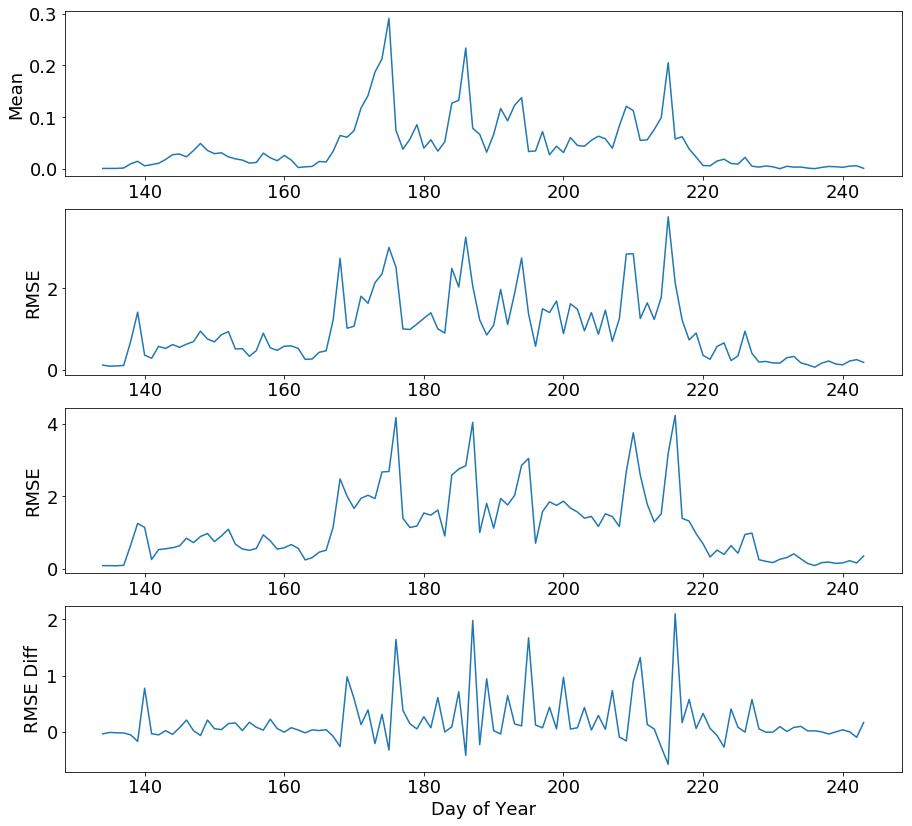

In [109]:
plt.rcParams['figure.figsize'] = [15,14]

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}

plt.rc('font', **font)

fig = plt.figure()

ax = fig.add_subplot(411)
y_years = np.array(np.split(results_active_only_grid[1]['All'][0][0], 10, axis=2))
y_years = np.reshape(y_years, (10*33*55, 110))

_ = plt.plot(map(lambda x: x.strftime('%j'), Y_detection_c.dates[:110]), np.mean(y_years, axis=0))

_ = plt.ylabel('Mean')


# 1
ax = fig.add_subplot(412)

y_years = np.array(np.split(results_active_only_grid[1]['All'][0][0], 10, axis=2))
y_hat_years = np.array(np.split(results_active_only_grid[1]['All'][0][1], 10, axis=2))

y_years = np.reshape(y_years, (10*33*55, 110))
y_hat_years = np.reshape(y_hat_years, (10*33*55, 110))

metric1 = metrics.root_mean_squared_error
rmse_years1 = metric(y_years, y_hat_years, axis=0)

_ = plt.plot(map(lambda x: x.strftime('%j'), Y_detection_c.dates[:110]), rmse_years1)
#_ = plt.xlabel('Years')
_ = plt.ylabel('RMSE')

# 2
ax = fig.add_subplot(413)
y_years = np.array(np.split(results_auto_grid[1]['None'][0][0], 10, axis=2))
y_hat_years = np.array(np.split(results_auto_grid[1]['None'][0][1], 10, axis=2))

y_years = np.reshape(y_years, (10*33*55, 110))
y_hat_years = np.reshape(y_hat_years, (10*33*55, 110))

metric2 = metrics.root_mean_squared_error
rmse_years2 = metric(y_years, y_hat_years, axis=0)

_ = plt.plot(map(lambda x: x.strftime('%j'), Y_detection_c.dates[:110]), rmse_years2)
#_ = plt.xlabel('Years')
_ = plt.ylabel('RMSE')

# 3
ax = fig.add_subplot(414)
_ = plt.plot(map(lambda x: x.strftime('%j'), Y_detection_c.dates[:110]), rmse_years2-rmse_years1)
_ = plt.xlabel('Day of Year')
_ = plt.ylabel('RMSE Diff')

### Errors by fire size

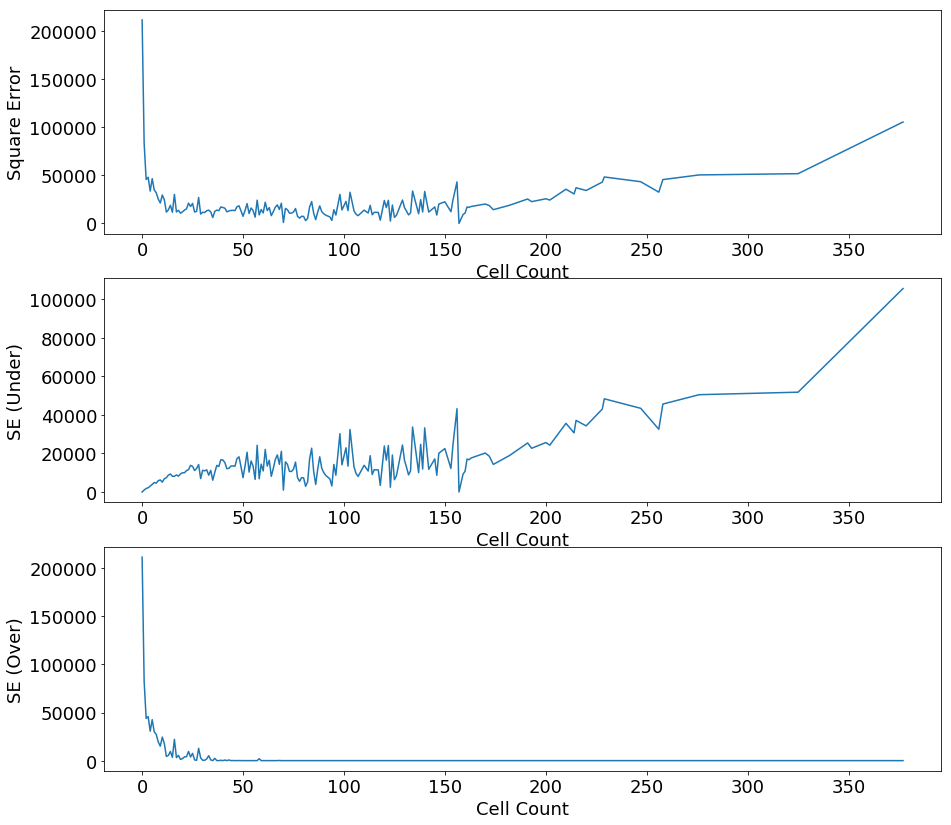

In [182]:
plt.rcParams['figure.figsize'] = [15,14]

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}

plt.rc('font', **font)

fig = plt.figure()

errors = zip(results_active_only_grid[1]['All'][0][0].flatten(), np.square(results_active_only_grid[1]['All'][0][0].flatten()-results_active_only_grid[1]['All'][0][1].flatten()))
errors2 = zip(results_active_only_grid[1]['All'][0][0].flatten(), results_active_only_grid[1]['All'][0][0].flatten()-results_active_only_grid[1]['All'][0][1].flatten())

d1 = defaultdict(int)
d2 = defaultdict(int)
d3 = defaultdict(int)
d4 = defaultdict(int)


def func(a,b):
    a[b[0]] = a[b[0]] + b[1]
    return a

def func2(a,b):
    a[b[0]] = a[b[0]] + 1
    return a

def func3(a,b):
    if b[1] > 0:
        a[b[0]] = a[b[0]] + np.square(b[1])
    else:
        a[b[0]] = a[b[0]]
    return a

def func4(a,b):
    if b[1] < 0:
        a[b[0]] = a[b[0]] + np.square(b[1])
    else:
        a[b[0]] = a[b[0]]
    return a

results = functools.reduce(func, errors, d1)
results2 = functools.reduce(func2, errors, d2)
results3 = functools.reduce(func3, errors2, d3)
results4 = functools.reduce(func4, errors2, d4)


ax = fig.add_subplot(311)
x = []
y = []
for k,v in results.iteritems():
    x.append(k)
    y.append(v)

_ = plt.plot(x,y)
_ = plt.xlabel('Cell Count')
_ = plt.ylabel('Square Error')

ax = fig.add_subplot(311)



ax = fig.add_subplot(312)

x = []
y = []
for k,v in results3.iteritems():
    x.append(k)
    y.append(v) 

_ = plt.plot(x,y)
_ = plt.xlabel('Cell Count')
_ = plt.ylabel('SE (Under)')

ax = fig.add_subplot(313)

x = []
y = []
for k,v in results4.iteritems():
    x.append(k)
    y.append(v) 

_ = plt.plot(x,y)
_ = plt.xlabel('Cell Count')
_ = plt.ylabel('SE (Over)')

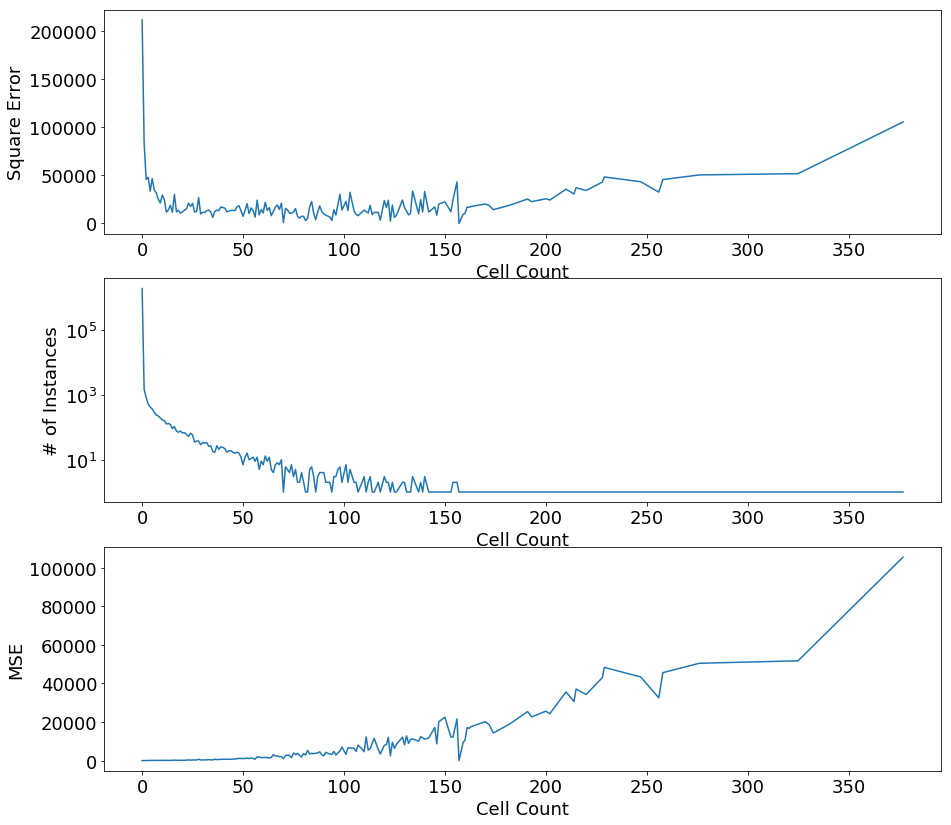

In [181]:
fig = plt.figure()

ax = fig.add_subplot(311)
x = []
y = []
for k,v in results.iteritems():
    x.append(k)
    y.append(v)

_ = plt.plot(x,y)
_ = plt.xlabel('Cell Count')
_ = plt.ylabel('Square Error')


ax = fig.add_subplot(312)
x = []
y = []
for k,v in results2.iteritems():
    x.append(k)
    y.append(v)

_ = plt.semilogy(x,y)
_ = plt.xlabel('Cell Count')
_ = plt.ylabel('# of Instances')


ax = fig.add_subplot(313)
x = []
y = []
for k,v in results.iteritems():
    x.append(k)
    y.append(v/float(results2[k])) 

_ = plt.plot(x,y)
_ = plt.xlabel('Cell Count')
_ = plt.ylabel('MSE')

### Magnitude of Errors

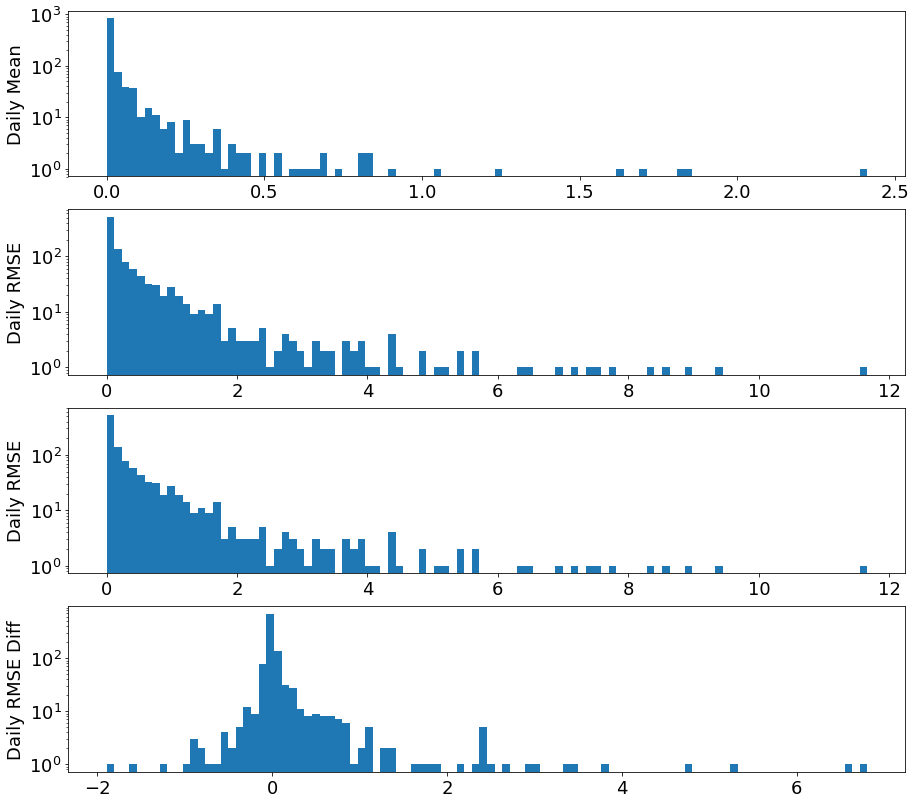

In [132]:
plt.rcParams['figure.figsize'] = [15,14]

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}

plt.rc('font', **font)

fig = plt.figure()

metric = metrics.root_mean_squared_error

ax = fig.add_subplot(411)
counts = np.mean(results_active_only_grid[1]['All'][0][0].reshape(33*55,1100), axis=0)
_ = plt.hist(counts, bins=100)
_ = plt.ylabel('Daily Mean')
plt.yscale('log', nonposy='clip')


ax = fig.add_subplot(412)
error1 = metric(results_active_only_grid[1]['All'][0][0].reshape(33*55,1100), results_active_only_grid[1]['All'][0][1].reshape(33*55,1100), axis=0)
_ = plt.hist(error1, bins=100)
_ = plt.ylabel('Daily RMSE')
plt.yscale('log', nonposy='clip')


ax = fig.add_subplot(413)

error2 = metric(results_auto_grid[1]['None'][0][0].reshape(33*55,1100), results_auto_grid[1]['None'][0][1].reshape(33*55,1100), axis=0)
_ = plt.hist(error1, bins=100)
_ = plt.ylabel('Daily RMSE')
plt.yscale('log', nonposy='clip')

ax = fig.add_subplot(414)
_ = plt.hist(error2-error1, bins=100)
_ = plt.ylabel('Daily RMSE Diff')
plt.yscale('log', nonposy='clip')



### Expected Change in Counts Between Days

In [ ]:
def simulate_day(prev_fires, coeff, random=True, zip_model=False):
    if random:
        if zip_model:
            zip_means = coeff[0]
            coeff = coeff[1]
            
            logit_coeff = coeff[0]
            poisson_coeff = coeff[1]
            
            new = logit_coeff[0]
            new +=  np.sum((np.flip(np.log(np.array(prev_fires)+1),0) - zip_means) * np.array(logit_coeff[1:]))
            
            pi = 1/(1+np.exp(-new))
            
            
            new = poisson_coeff[0]
            new +=  np.sum((np.flip(np.log(np.array(prev_fires)+1),0) - zip_means) * np.array(poisson_coeff[1:]))
            
            lambda_ = np.exp(new)
            
            lam.append(lambda_)
            
            is_zero = np.random.binomial(1, 1-pi)
            new = is_zero * np.random.poisson(new)
            
        else:
            new = coeff[0]
            new +=  np.sum(np.flip(np.log(np.array(prev_fires)+1),0) * np.array(coeff[1:]))
            new = np.exp(new)
                
            lam2.append(lam2)
            new = np.random.poisson(new)
            
    return np.concatenate([prev_fires[1:], [new]]), new

def count_zeros(arr, ind):
    count = 0
    for i in range(ind, -1, -1):
        if arr[i] == 0:
            count += 1
        else:
            return count
    return count

def simulate_days(prev_fires, coeff, days, random=True, zero_death=1, zip_model=False):
    cur = prev_fires
    hist = [prev_fires[-1]]
    for day in range(days):
        num_prev_zeros = count_zeros(hist, day)
        if (zero_death > 0) and (num_prev_zeros >= zero_death):
            hist += [0] * (days - day)
            return cur, hist, day-1
        cur,new = simulate_day(cur, coeff, random, zip_model=zip_model)
        hist.append(new)
    return cur, hist, None

def simulate(prev_fires_arr, coeff, days, times, zero_death=1, zip_model=False):
    cur = []
    hist = []
    day_end = np.zeros(days+1)
    for t in range(times):
        prev_fires = prev_fires_arr[t]
        new_cur,new_hist,day = simulate_days(prev_fires, coeff, days, zero_death=zero_death, zip_model=zip_model)
        cur.append(new_cur)
        hist.append(new_hist)
        if day is not None:
            day_end[day+1] += 1
    
    return cur, hist, day_end

In [591]:
zip_params = [[-5.30422653e-01, -9.04580094e-01,  4.79652165e-02,  4.76853541e-02,
       -8.14872031e-02,  9.45073504e-04, -7.38566570e-02, -5.50520473e-02,
        7.93362003e-02, -2.33224917e-02, -3.47471786e-02], [2.58877260e+00,
        4.49447024e-01,  2.28586871e-02, -4.48726441e-03,  1.47596671e-02,
        4.63004902e-02, -2.28040587e-02,  2.04581114e-02, -6.93798034e-02,
        8.48256505e-02,  4.57105462e-02]]

zip_means = [1.97742013, 1.39389888, 1.07652052, 0.87382713, 0.76265957,
 0.69270579, 0.63636549, 0.57127233, 0.5058478,  0.45250233]

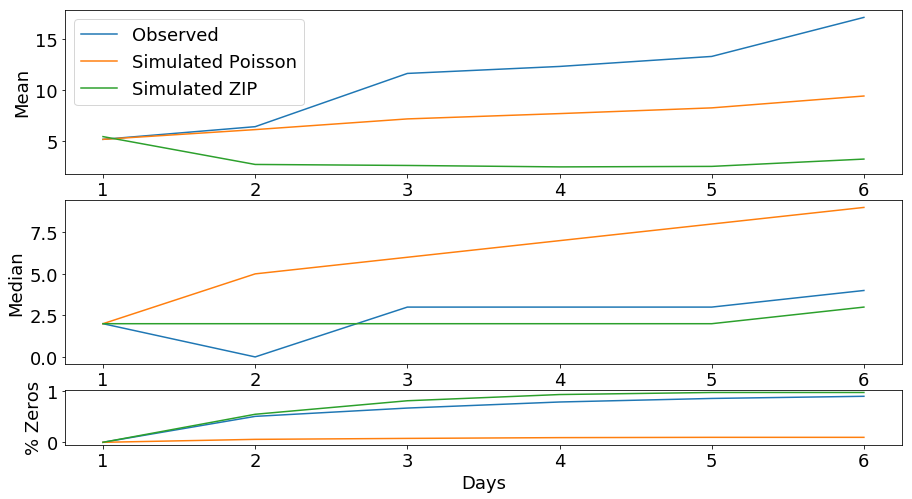

In [594]:
plt.rcParams['figure.figsize'] = [15,8]

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}

plt.rc('font', **font)



fig = plt.figure()
gs = gridspec.GridSpec(3,1, height_ratios=[3,3,1])
ax0 = plt.subplot(gs[0])

sel = (X_grid_dict[1][0]['num_det_1'].values==0) & (X_grid_dict[1][0]['num_det'].values!=0)
day1 = X_grid_dict[1][0]['num_det'].values[sel]

# Simulate
#orig = np.zeros(num_hist)
#orig[-1] = 5
days = 6
num_hist = 10
num_trials = len(day1)
num_trials_mult = 3

orig = np.zeros((num_trials, num_hist))
orig[:,-1] = day1
orig[:,-2] = X_grid_dict[1][0]['num_det_1'].values[sel]
orig[:,-3] = X_grid_dict[1][0]['num_det_1'].values[sel]
orig[:,-4] = X_grid_dict[1][0]['num_det_1'].values[sel]
orig[:,-5] = X_grid_dict[1][0]['num_det_1'].values[sel]
orig[:,-6] = X_grid_dict[1][0]['num_det_1'].values[sel]
orig[:,-7] = X_grid_dict[1][0]['num_det_1'].values[sel]
orig[:,-8] = X_grid_dict[1][0]['num_det_1'].values[sel]
orig[:,-9] = X_grid_dict[1][0]['num_det_1'].values[sel]
orig[:,-10] = X_grid_dict[1][0]['num_det_1'].values[sel]
orig = np.repeat(orig, num_trials_mult, axis=0)
cur, hist0,day_end = simulate(orig, models_active_only_grid_mem['Memory'][0][0][0].params,days-1, num_trials * num_trials_mult, zero_death=1)
hist0 = np.array(hist0)

cur, hist1,day_end2 = simulate(orig, (zip_means, zip_params), days-1, num_trials, zero_death=1, zip_model=True)
hist1 = np.array(hist1)


day1_sim = hist0[np.all(hist0[:,:1] != 0, axis=1), 0]
day1_sim2 = hist1[np.all(hist1[:,:1] != 0, axis=1), 0]

sel = sel
day2 = X_grid_dict[1][0]['num_det_target'].values[sel]
day2_sim = hist0[np.all(hist0[:,:2] != 0, axis=1), 1]
day2_sim2 = hist1[np.all(hist1[:,:2] != 0, axis=1), 1]

sel = sel & (X_grid_dict[1][0]['num_det_target'].values!=0)
day3 = X_grid_dict[2][0]['num_det_target'].values[sel]
day3_sim = hist0[np.all(hist0[:,:3] != 0, axis=1), 2]
day3_sim2 = hist1[np.all(hist1[:,:3] != 0, axis=1), 2]

sel = sel & (X_grid_dict[2][0]['num_det_target'].values!=0)
day4 = X_grid_dict[3][0]['num_det_target'].values[sel]
day4_sim = hist0[np.all(hist0[:,:4] != 0, axis=1), 3]
day4_sim2 = hist1[np.all(hist1[:,:4] != 0, axis=1), 3]

sel = sel & (X_grid_dict[3][0]['num_det_target'].values!=0)
day5 = X_grid_dict[4][0]['num_det_target'].values[sel]
day5_sim = hist0[np.all(hist0[:,:5] != 0, axis=1), 4]
day5_sim2 = hist1[np.all(hist1[:,:5] != 0, axis=1), 4]

sel = sel & (X_grid_dict[4][0]['num_det_target'].values!=0)
day6 = X_grid_dict[5][0]['num_det_target'].values[sel]
day6_sim = hist0[np.all(hist0[:,:6] != 0, axis=1), 5]
day6_sim2 = hist1[np.all(hist1[:,:6] != 0, axis=1), 5]

values = [day1, day2, day3, day4, day5, day6]
values_sim = [day1_sim, day2_sim, day3_sim, day4_sim, day5_sim, day6_sim]
values_sim2 = [day1_sim2, day2_sim2, day3_sim2, day4_sim2, day5_sim2, day6_sim2]

_ = ax0.plot(range(1,days+1), map(np.mean, values), label='Observed')
_ = ax0.plot(range(1,days+1), map(np.mean, values_sim), label='Simulated Poisson')
_ = ax0.plot(range(1,days+1), map(np.mean, values_sim2), label='Simulated ZIP')
_ = ax0.set_ylabel('Mean')
_ = ax0.legend()
#ax0.boxplot(values, sym='')

ax1 = plt.subplot(gs[1], sharex=ax0)
_ = ax1.plot(range(1,days+1), map(np.median, values), label='Observed')
_ = ax1.plot(range(1,days+1), map(np.median, values_sim), label='Simulated Poisson')
_ = ax1.plot(range(1,days+1), map(np.median, values_sim2), label='Simulated ZIP')
_ = ax1.set_ylabel('Median')

ax2 = plt.subplot(gs[2], sharex=ax0)
_ = ax2.plot(range(1,days+1), np.cumsum(map(lambda x: np.sum(x==0)/float(len(day1)), values)))
_ = ax2.plot(range(1,days+1), np.cumsum(day_end)/num_trials)
_ = ax2.plot(range(1,days+1), np.cumsum(day_end2)/num_trials)
_ = ax2.set_ylabel('% Zeros')
_ = ax2.set_xlabel('Days')

In [ ]:
print np.mean(lam), np.mean(lam2)

In [ ]:
np.shape(lam), np.shape(lam2)

In [ ]:
2